
# Inspecting your data in tables

This tutorial shows how to leverage `xarray` and `pandas` to easily transform `xsnowDataset`s into tidy, tabular views that you can scan like a spreadsheet.

In particular,
1) Select an individual profile and view it as a `pandas.DataFrame`
2) Keep or drop length-1 dimensions with `.squeeze()` when flattening arrays
3) Inspect data points of your interest by applying a mask with `.where()`
4) Export summaries to pandas `Series`/`DataFrame` or NumPy arrays



```{admonition} Handy helpers
:class: note

| Object | Method | Description |
|---------|---------|-------------|
| **Dataset / DataArray** | [`.squeeze()`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.squeeze.html#xarray.Dataset.squeeze) | Squeeze out all dimensions of length 1. |
| **Dataset / DataArray** | [`.to_dataframe()`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.to_dataframe.html#xarray.Dataset.to_dataframe) | Convert this dataset or data array into a tidy [`pandas.DataFrame`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). |
| **DataArray** | [`.to_pandas()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.to_pandas.html#xarray.DataArray.to_pandas) | Convert this array into a pandas object (`1D → Series`, `2D → DataFrame`). |
| **DataArray** | [`.to_numpy()`](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.to_numpy.html#xarray.DataArray.to_numpy) | Coerce to a NumPy array. |
```


In [ ]:

import xsnow
import pandas as pd

xs = xsnow.single_profile_timeseries()
print(xs.sizes)



## 1. Inspect a single profile as a table

Select one timestamp/slope/realization and turn the subset of variables into a `DataFrame` for a spreadsheet-like view.


In [13]:

profile = xs.isel(time=-1, slope=0, realization=[0])
profile.sizes


Frozen({'location': 1, 'realization': 1, 'layer': 59})

You see that `sel` and `isel` squeeze length-1 dimensions by default when given as scalars (e.g., time and slope in the example above) unless they are given as lists (e.g., realization). 

In [14]:

profile[['height', 'sk38', 'density']].to_dataframe()


height  sk38     density  \
location        realization layer                                 
Kasererwinkl_C6 0           0        1.750000  6.00  520.200012   
                            1        3.500000  3.50  520.000000   
                            2        5.250000  3.53  519.500000   
                            3        7.000000  2.51  518.900024   
                            4        8.850000  2.04  347.700012   
                            5       10.720000  2.06  347.100006   
                            6       12.580000  2.08  346.600006   
                            7       14.460000  2.10  346.000000   
                            8       16.330000  2.12  345.399994   
                            9       18.209999  2.14  344.899994   
                            10      20.090000  2.16  344.399994   
                            11      21.980000  2.19  343.899994   
                            12      23.860001  2.21  343.500000   
                            13      25.750000  2.23  343.100006   
                            14      27.639999  2.25  342.799988   
                            15      29.530001  2.10  342.500000   
                            16      31.240000  2.15  316.000000   
                            17      32.950001  2.17  316.100006   
                            18      34.450001  2.39  520.200012   
                            19      36.450001  2.06  347.000000   
                            20      38.439999  2.08  347.500000   
                            21      40.439999  2.10  347.700012   
                            22      42.439999  2.11  347.899994   
                            23      44.439999  2.11  348.700012   
                            24      46.439999  2.81  520.900024   
                            25      48.439999  1.16  519.099976   
                            26      50.419998  1.44  272.500000   
                            27      52.380001  1.47  278.200012   
                            28      54.320000  1.45  279.600006   
                            29      56.270000  1.41  279.399994   
                            30      58.220001  0.75  279.000000   
                            31      59.779999  0.93  210.100006   
                            32      61.349998  0.91  209.199997   
                            33      62.919998  0.89  208.199997   
                            34      64.510002  0.86  207.100006   
                            35      66.099998  0.83  206.100006   
                            36      67.699997  0.79  204.899994   
                            37      69.309998  0.77  203.000000   
                            38      70.919998  0.73  202.800003   
                            39      71.739998  1.74   61.000000   
                            40      72.440002  0.68  202.399994   
                            41      73.500000  0.38  237.600006   
                            42      75.599998  0.58  178.100006   
                            43      76.730003  0.52  251.899994   
                            44      77.889999  0.37  282.700012   
                            45      79.019997  0.33  268.000000   
                            46      79.540001  0.21  260.799988   
                            47      81.599998  0.34  236.300003   
                            48      83.650002  0.09  236.600006   
                            49      85.980003  6.00  226.399994   
                            50      87.150002  6.00  216.000000   
                            51      89.440002  6.00  218.699997   
                            52      90.540001  6.00  220.600006   
                            53      93.330002  6.00  177.600006   
                            54      95.239998  6.00  130.800003   
                            55      96.980003  6.00  149.399994   
                            56      99.010002  6.00  137.399994   
                            57     101.050003  6.00  127.699997   
                   

The DataFrame is indexed by the dimensions of the former dataset (unless we squeezed them out as we did for slope/time). It contains the data variables that we requested (`['height', 'sk38', 'density']`), and it contains all the coordinates (`['time', 'slope', 'latitude', 'longitude', 'altitude', 'inclination', 'azimuth', 'z']`).


## 2. Mask values before turning them into tables

For larger datasets, you often want to keep only layers that pass a condition. Build a simple mask (with `where()`---see also [Subsetting and Filtering](./subsetting_filtering.ipynb)), preserve the grid shape, and inspect the remaining rows with pandas.


In [16]:
xs['rta'] = xs['ssi']  # need an RTA with meaningful values, this hack doesn't matter for tutorial concept

In [28]:

# Stability index across time and layer
xs2d = xs.squeeze()
print('Before squeeze:', xs.sizes)
print('After squeeze :', xs2d.sizes)

Before squeeze: Frozen({'location': 1, 'time': 381, 'slope': 1, 'realization': 1, 'layer': 59})
After squeeze : Frozen({'time': 381, 'layer': 59})


In [ ]:
sk38_masked = xs2d[['sk38', 'rta']].where(xs2d['rta'] > 0.8)

In [20]:

sk38_masked.to_dataframe().dropna()


sk38   rta  slope  realization         location  \
time                layer                                                    
2024-01-17 16:00:00 19     2.04  0.85      0            0  Kasererwinkl_C6   
                    23     1.58  0.87      0            0  Kasererwinkl_C6   
                    26     0.74  1.00      0            0  Kasererwinkl_C6   
2024-01-17 17:00:00 19     2.04  0.85      0            0  Kasererwinkl_C6   
                    23     1.58  0.87      0            0  Kasererwinkl_C6   
...                         ...   ...    ...          ...              ...   
2024-02-02 12:00:00 36     0.79  0.81      0            0  Kasererwinkl_C6   
                    37     0.77  0.81      0            0  Kasererwinkl_C6   
                    39     1.74  0.96      0            0  Kasererwinkl_C6   
                    40     0.68  0.97      0            0  Kasererwinkl_C6   
                    42     0.58  0.89      0            0  Kasererwinkl_C6   

                           latitude  longitude  altitude  inclination  \
time                layer                                               
2024-01-17 16:00:00 19     47.10183   11.61714    1681.0           16   
                    23     47.10183   11.61714    1681.0           16   
                    26     47.10183   11.61714    1681.0           16   
2024-01-17 17:00:00 19     47.10183   11.61714    1681.0           16   
                    23     47.10183   11.61714    1681.0           16   
...                             ...        ...       ...          ...   
2024-02-02 12:00:00 36     47.10183   11.61714    1681.0           16   
                    37     47.10183   11.61714    1681.0           16   
                    39     47.10183   11.61714    1681.0           16   
                    40     47.10183   11.61714    1681.0           16   
                    42     47.10183   11.61714    1681.0           16   

                           azimuth          z  
time                layer                      
2024-01-17 16:00:00 19         270 -39.989998  
                    23         270 -31.989998  
                    26         270 -25.989998  
2024-01-17 17:00:00 19         270 -39.989998  
                    23         270 -31.989998  
...                            ...        ...  
2024-02-02 12:00:00 36         270 -35.510002  
                    37         270 -33.900002  
                    39         270 -31.470001  
                    40         270 -30.769997  
                    42         270 -27.610001  

[1950 rows x 11 columns]


## 3. Summaries and exports

After masking, let's reduce along `layer` and export to different data structures. Note that you would mostly run computations on the `DataArray`s, no need to convert them.

Here, we are interested in the minimum SK38 per timestamp:


In [23]:

sk38_min = sk38_masked['sk38'].min('layer', skipna=True)
print(sk38_min)


<xarray.DataArray 'sk38' (time: 381)> Size: 2kB
array([0.74, 0.74, 0.74, 0.74, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.13, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.11, 0.11, 0.11, 0.13,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.11, 0.11, 0.11, 0.09, 0.09,
       0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.1 , 0.1 , 0.1 , 0.11, 0.11,
       0.11, 0.11, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.17, 0.17, 0.17, 0.17, 0.06, 0.05, 0.13, 0.18, 0.05, 0.05, 0.05,
       0.09, 0.09, 0.1 , 0.11, 0.22, 0.23, 0.23, 0.26, 0.27, 0.27, 0.27,
   

In [24]:

sk38_min.to_dataframe()


slope  realization         location  latitude  longitude  \
time                                                                            
2024-01-17 16:00:00      0            0  Kasererwinkl_C6  47.10183   11.61714   
2024-01-17 17:00:00      0            0  Kasererwinkl_C6  47.10183   11.61714   
2024-01-17 18:00:00      0            0  Kasererwinkl_C6  47.10183   11.61714   
2024-01-17 19:00:00      0            0  Kasererwinkl_C6  47.10183   11.61714   
2024-01-17 20:00:00      0            0  Kasererwinkl_C6  47.10183   11.61714   
...                    ...          ...              ...       ...        ...   
2024-02-02 08:00:00      0            0  Kasererwinkl_C6  47.10183   11.61714   
2024-02-02 09:00:00      0            0  Kasererwinkl_C6  47.10183   11.61714   
2024-02-02 10:00:00      0            0  Kasererwinkl_C6  47.10183   11.61714   
2024-02-02 11:00:00      0            0  Kasererwinkl_C6  47.10183   11.61714   
2024-02-02 12:00:00      0            0  Kasererwinkl_C6  47.10183   11.61714   

                     altitude  inclination  azimuth  sk38  
time                                                       
2024-01-17 16:00:00    1681.0           16      270  0.74  
2024-01-17 17:00:00    1681.0           16      270  0.74  
2024-01-17 18:00:00    1681.0           16      270  0.74  
2024-01-17 19:00:00    1681.0           16      270  0.74  
2024-01-17 20:00:00    1681.0           16      270  0.75  
...                       ...          ...      ...   ...  
2024-02-02 08:00:00    1681.0           16      270  0.57  
2024-02-02 09:00:00    1681.0           16      270  0.57  
2024-02-02 10:00:00    1681.0           16      270  0.57  
2024-02-02 11:00:00    1681.0           16      270  0.57  
2024-02-02 12:00:00    1681.0           16      270  0.58  

[381 rows x 9 columns]

In [25]:

sk38_min.to_pandas()


time
2024-01-17 16:00:00    0.74
2024-01-17 17:00:00    0.74
2024-01-17 18:00:00    0.74
2024-01-17 19:00:00    0.74
2024-01-17 20:00:00    0.75
                       ... 
2024-02-02 08:00:00    0.57
2024-02-02 09:00:00    0.57
2024-02-02 10:00:00    0.57
2024-02-02 11:00:00    0.57
2024-02-02 12:00:00    0.58
Freq: h, Name: sk38, Length: 381, dtype: float32

In [26]:

sk38_min.to_numpy()


array([0.74, 0.74, 0.74, 0.74, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.13, 0.1 , 0.1 , 0.1 , 0.1 , 0.1 , 0.11, 0.11, 0.11, 0.13,
       0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.11, 0.11, 0.11, 0.09, 0.09,
       0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.1 , 0.1 , 0.1 , 0.11, 0.11,
       0.11, 0.11, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.15, 0.15, 0.15,
       0.15, 0.15, 0.15, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,
       0.17, 0.17, 0.17, 0.17, 0.06, 0.05, 0.13, 0.18, 0.05, 0.05, 0.05,
       0.09, 0.09, 0.1 , 0.11, 0.22, 0.23, 0.23, 0.26, 0.27, 0.27, 0.27,
       0.27, 0.27, 0.28, 0.28, 0.31, 0.31, 0.25, 0.

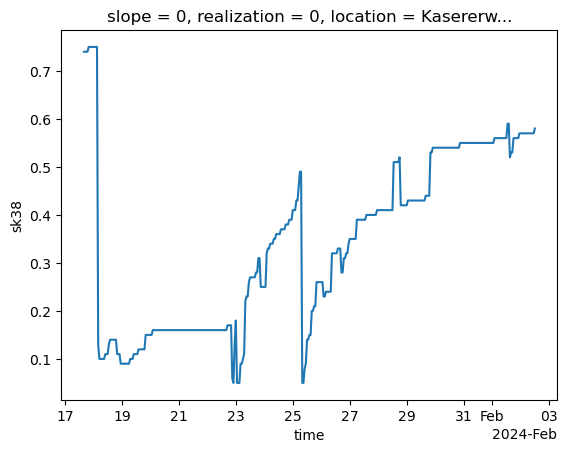

In [ ]:
ax = sk38_min.plot()


## 5. Summary

- Use `.squeeze()` to flatten length-1 dimensions before converting to tables.
- `.to_dataframe()` yields tidy, multi-index tables you can filter further with pandas.
- `.where()` keeps the dataset grid intact; use pandas utilities like `.dropna()` to focus on valid rows.
- Reduce along `layer` (or other dimensions) and convert to pandas or NumPy for convenient inspection or simple plotting.
